#KLASIFIKASI HEART DISEASE MENGGUNAKAN METODE RANDOM FOREST, MLP, DAN XGBOOST DENGAN VARIANCE INFLATION FACTOR FEATURE SELECTION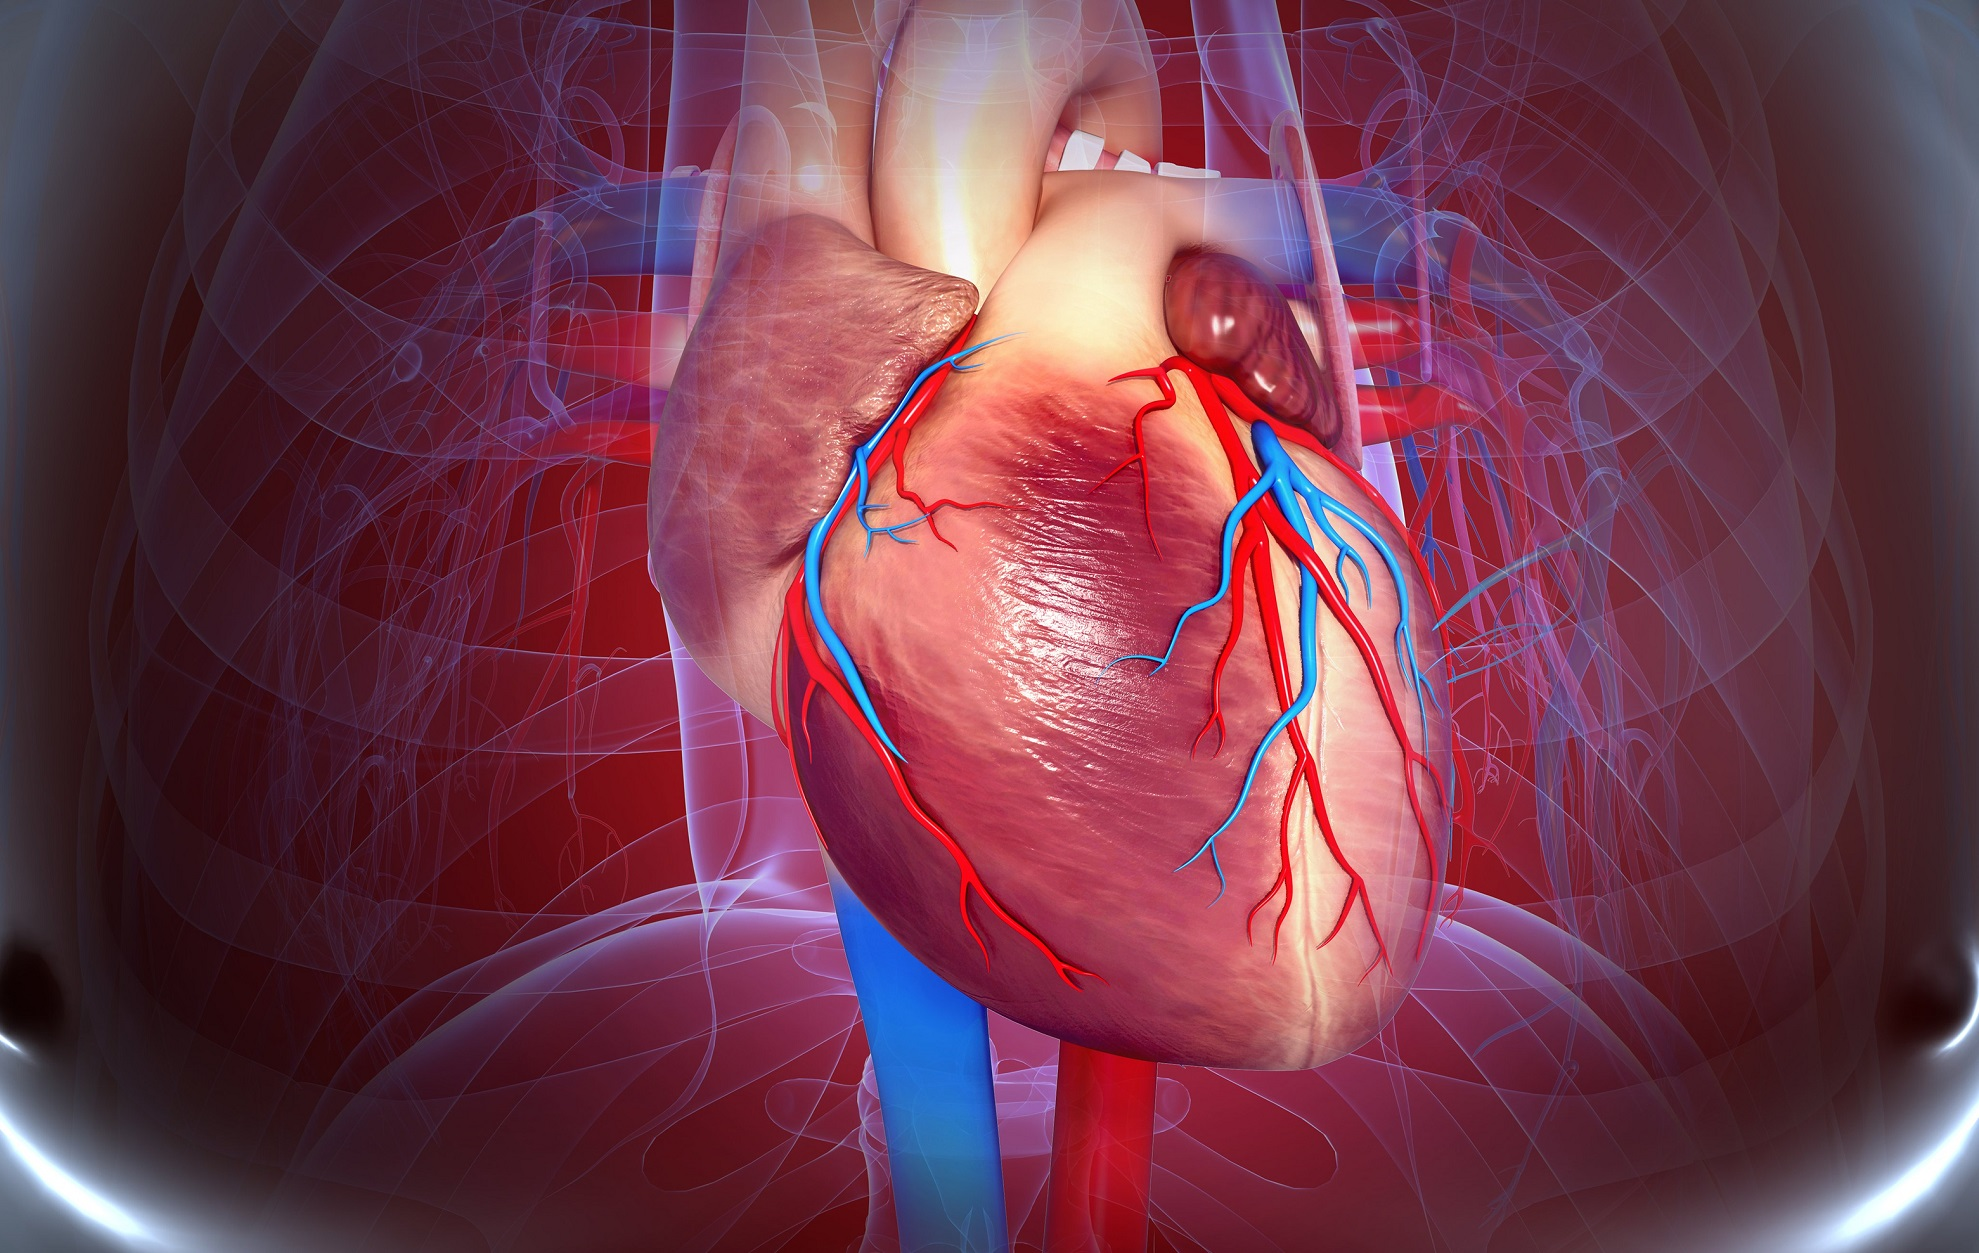

# Latar Belakang

Penyakit jantung merupakan salah satu penyebab kematian teratas di dunia. Penyakit jantung terjadi saat darah tidak dapat mengalir menuju jantung (Yadav, D.C., dkk., 2020). Menurut World Health Organization (WHO), sekitar 17.9 juta orang meninggal akibat penyakit jantung setiap tahunnya. Oleh karena itu, diperlukan deteksi secepatnya pada awal pemeriksaan sebelum menuju masalah selanjutnya yang lebih serius.
Pada penelitian sebelumnya oleh Yadav, D.C., dkk. melakukan prediksi dengan menggunakan feature selection pearson correlation melalui metode klasifikasi Random Forest, dengan features yang terpilih adalah cp, exang, oldpeak.


# Rumusan Masalah

1.	Apa saja features yang terpilih pada dataset heart disease jika menggunakan Variance Inflation Factor ?
2.	Apa saja hyperparameter optimization pada metode Random Forest, Multilayer Perceptron, dan XGboost Classifier ?
3.	Bagaimana penerapan k-fold cross validation pada dataset heart disease ?
4.	Bagaimana nilai dari alat evaluasi (akurasi, recall, presisi, dan f1 score) pada ketiga metode klasifikasi yang digunakan?


#Tujuan

1.	Mengetahui features yang terpilih pada dataset heart disease jika menggunakan Variance Inflation Factor.
2.	Mengetahui hyperparameter optimization pada metode Random Forest, Multilayer Perceptron, dan XGboost Classifier.
3.	Mengetahui penerapan k-fold cross validation pada dataset heart disease.
4.	Mengetahui nilai dari alat evaluasi (akurasi, recall, presisi, dan f1 score) pada ketiga metode klasifikasi yang digunakan.


Dataset diambil dari kaggle dengan link sebagai berikut : https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset/data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import time


In [ ]:
file_path = "/content/drive/MyDrive/KSD/heart.csv"
data = pd.read_csv(file_path)

In [ ]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


# DATA PREPROCESSING

**A.1 PENGECHECKAN MISSING VALUES**

In [ ]:
# Menghitung total nilai null
num_missing = data.isnull().sum().sum()
print("Number of rows with missing values:", num_missing)

Number of rows with missing values: 0


In [ ]:
# Menghitung total data yang terduplikat
duplicate_rows = data.duplicated()
num_duplicates = duplicate_rows.sum()
print("Number of rows with duplicate values:", num_duplicates)

Number of rows with duplicate values: 723


In [ ]:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
data1 = data[categorical_cols].astype('category')
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   sex      1025 non-null   category
 1   cp       1025 non-null   category
 2   fbs      1025 non-null   category
 3   restecg  1025 non-null   category
 4   exang    1025 non-null   category
 5   slope    1025 non-null   category
 6   ca       1025 non-null   category
 7   thal     1025 non-null   category
 8   target   1025 non-null   category
dtypes: category(9)
memory usage: 10.5 KB


In [ ]:
print("Unique value in categorical column :")
for column in data1.select_dtypes(include='category'):
    unique_values = np.sort(data1[column].astype('object').unique())
    print(f"{column.ljust(7)} = {unique_values}")

Unique value in categorical column :
sex     = [0 1]
cp      = [0 1 2 3]
fbs     = [0 1]
restecg = [0 1 2]
exang   = [0 1]
slope   = [0 1 2]
ca      = [0 1 2 3 4]
thal    = [0 1 2 3]
target  = [0 1]


**Deskripsi atribut**

|Atribut|Deskripsi|
|-------|---------|
|sex| 0 : Perempuan, 1 : Laki-laki |
|cp| *chest pain* pasien |
|fbs|Tingkat gula darah > 120 mg/dl. ( 0: False, 1: True)|
|restecg|*Resting electrocardiographic results*|
|exang|*Exercise-induced angina*. ( 0 = False, 1: True)|
|slope| Kemiringan puncak latihan segmen ST|
|ca|Menampilkan nilai integer atau float dari nomor pembuluh besar jantung|
|thal|Thalassemia |
|target|0 : Peluang terkena penyakit jantung rendah , 1 : Peluang terkena penyakit jantung tinggi|
|chol|Tingkat kolesterol (mg/dl)|
|trestbps|Tekanan darah (mmHh)|


**A.2 CHECKING OUTLIERS WITH BOX PLOT dan A.3 NORMALISASI**


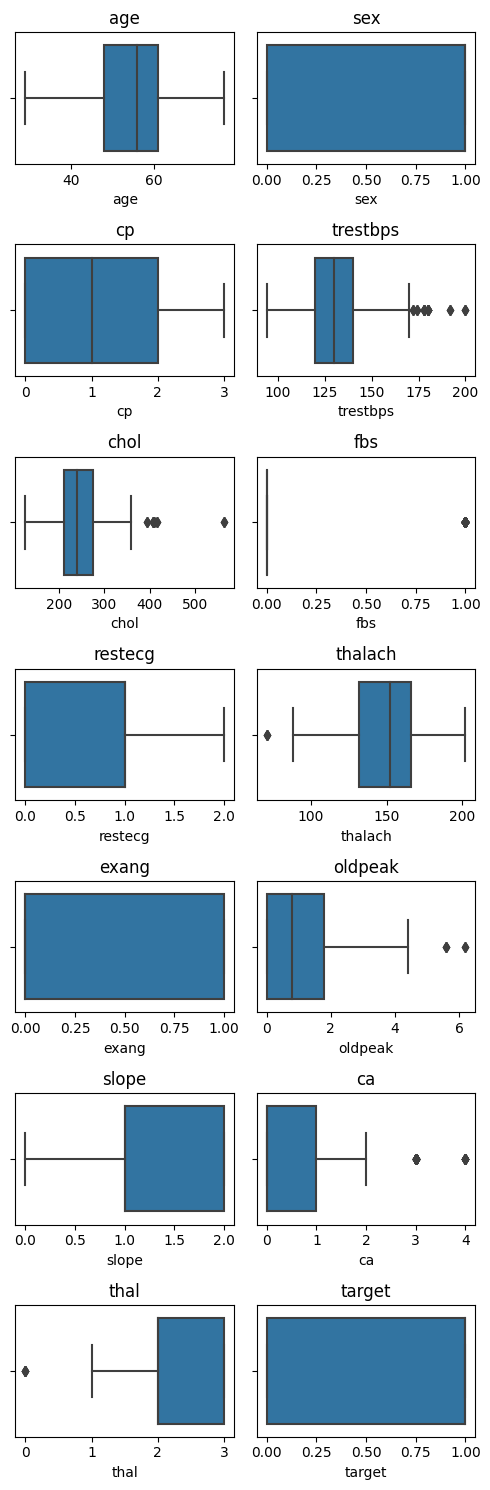

In [ ]:
# Outlier Checking with boxplot

fig, axes = plt.subplots(7, 2, figsize=(5, 15))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    sns.boxplot(x=data[column], ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

age: 0.00% outliers
sex: 0.00% outliers
cp: 0.00% outliers
trestbps: 2.93% outliers
chol: 1.56% outliers
fbs: 14.93% outliers
restecg: 0.00% outliers
thalach: 0.39% outliers
exang: 0.00% outliers
oldpeak: 0.68% outliers
slope: 0.00% outliers
ca: 8.49% outliers
thal: 0.68% outliers
target: 0.00% outliers


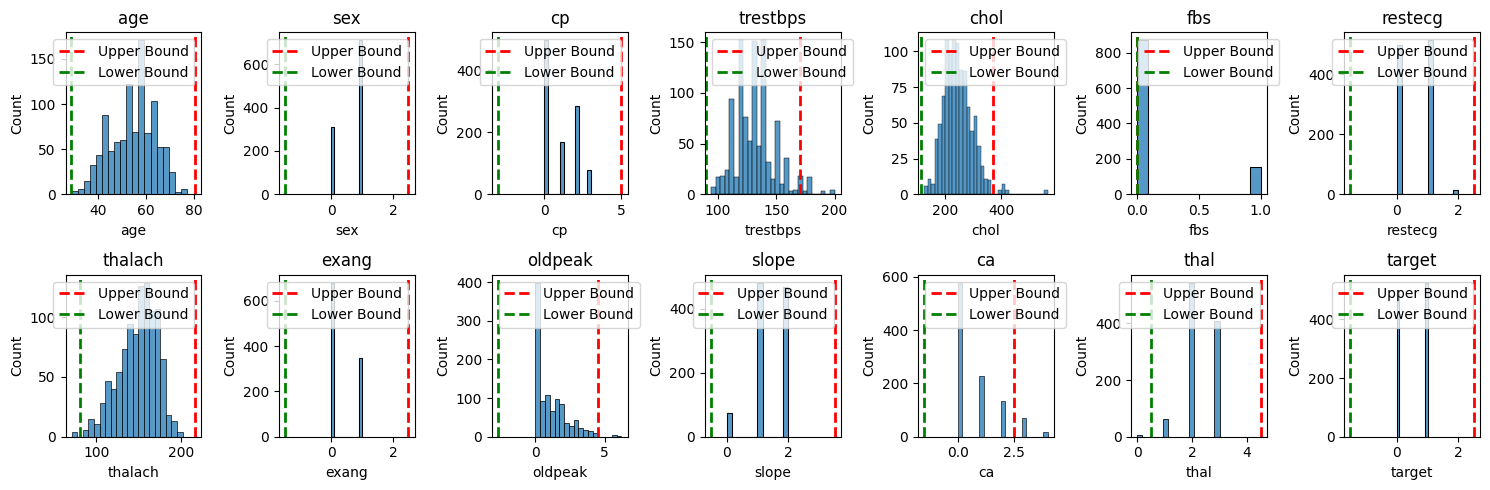

In [ ]:
#Checking Outlier with histogram

plt.figure(figsize=(15, 5))

for i, column in enumerate(data.columns, start=1):
    plt.subplot(2, 7, i)
    sns.histplot(x=data[column])
    plt.title(f'{column}')
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

# Plot upper and lower bounds
    plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2, label='Upper Bound')
    plt.axvline(lower_bound, color='g', linestyle='dashed', linewidth=2, label='Lower Bound')

    outliers_percentage = ((data[column] < lower_bound) | (data[column] > upper_bound)).mean() * 100

    plt.legend()
    print(f"{column}: {outliers_percentage:.2f}% outliers")


plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scale = scaler.fit_transform(data)
df_scale = pd.DataFrame(df_scale, columns=data.columns)
df_scale

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.479167,1.0,0.000000,0.292453,0.196347,0.0,0.5,0.740458,0.0,0.161290,1.0,0.50,1.000000,0.0
1,0.500000,1.0,0.000000,0.433962,0.175799,1.0,0.0,0.641221,1.0,0.500000,0.0,0.00,1.000000,0.0
2,0.854167,1.0,0.000000,0.481132,0.109589,0.0,0.5,0.412214,1.0,0.419355,0.0,0.00,1.000000,0.0
3,0.666667,1.0,0.000000,0.509434,0.175799,0.0,0.5,0.687023,0.0,0.000000,1.0,0.25,1.000000,0.0
4,0.687500,0.0,0.000000,0.415094,0.383562,1.0,0.5,0.267176,0.0,0.306452,0.5,0.75,0.666667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.625000,1.0,0.333333,0.433962,0.216895,0.0,0.5,0.709924,1.0,0.000000,1.0,0.00,0.666667,1.0
1021,0.645833,1.0,0.000000,0.292453,0.301370,0.0,0.0,0.534351,1.0,0.451613,0.5,0.25,1.000000,0.0
1022,0.375000,1.0,0.000000,0.150943,0.340183,0.0,0.0,0.358779,1.0,0.161290,0.5,0.25,0.666667,0.0
1023,0.437500,0.0,0.000000,0.150943,0.292237,0.0,0.0,0.671756,0.0,0.000000,1.0,0.00,0.666667,1.0


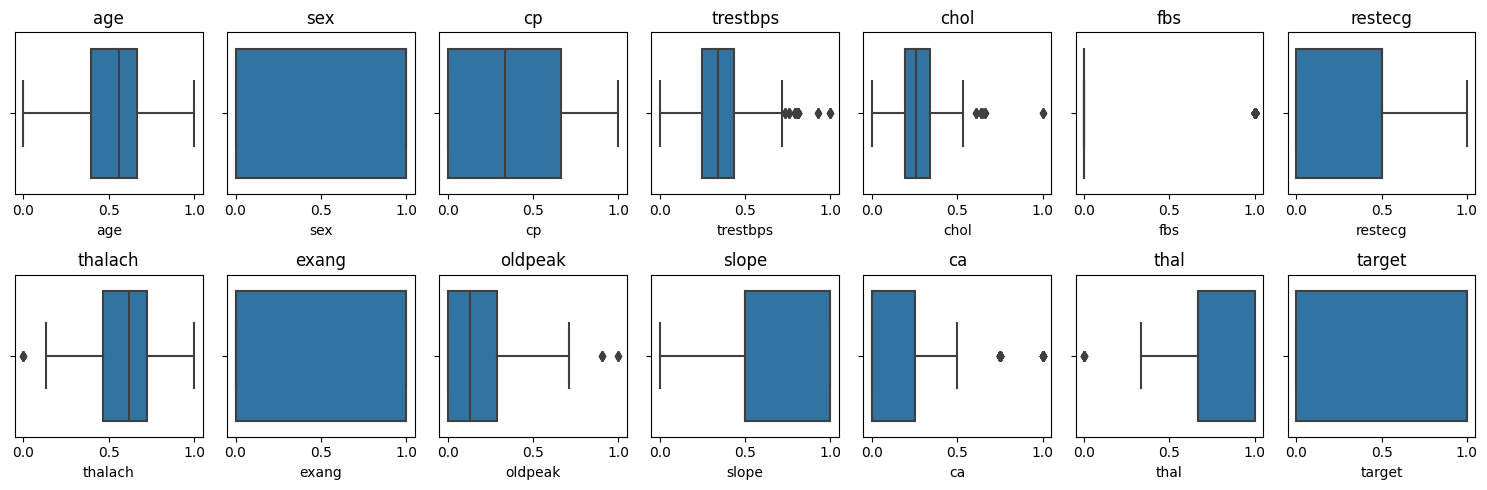

In [ ]:
# Outlier Checking with boxplot after normalitazion

fig, axes = plt.subplots(2, 7, figsize=(15, 5))
axes = axes.flatten()

for i, column in enumerate(df_scale.columns):
    sns.boxplot(x=df_scale[column], ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

age: 0.00% outliers
sex: 0.00% outliers
cp: 0.00% outliers
trestbps: 2.93% outliers
chol: 1.56% outliers
fbs: 14.93% outliers
restecg: 0.00% outliers
thalach: 0.39% outliers
exang: 0.00% outliers
oldpeak: 0.68% outliers
slope: 0.00% outliers
ca: 8.49% outliers
thal: 0.68% outliers
target: 0.00% outliers


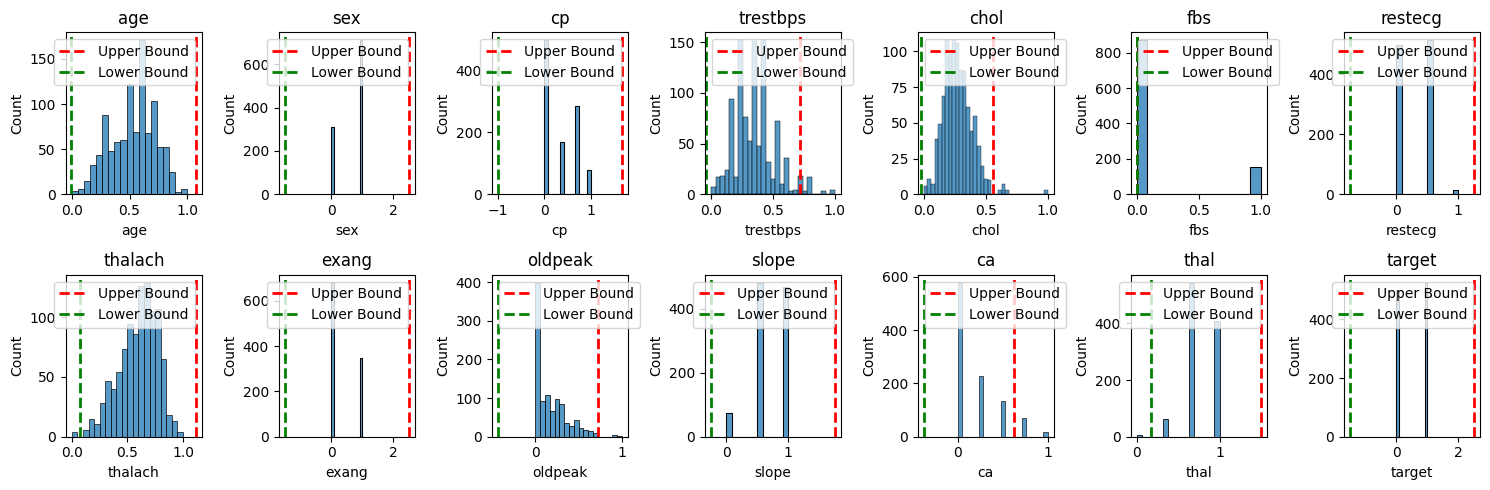

In [ ]:

plt.figure(figsize=(15, 5))
for i, column in enumerate(df_scale.columns, start=1):
    plt.subplot(2, 7, i)

    # Plot histogram
    sns.histplot(x=df_scale[column])
    plt.title(f'{column}')

    q1 = df_scale[column].quantile(0.25)
    q3 = df_scale[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Plot upper and lower bounds
    plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2, label='Upper Bound')
    plt.axvline(lower_bound, color='g', linestyle='dashed', linewidth=2, label='Lower Bound')

    outliers_percentage = ((df_scale[column] < lower_bound) | (df_scale[column] > upper_bound)).mean() * 100

    # Display the percentage of outliers
    print(f"{column}: {outliers_percentage:.2f}% outliers")
    plt.legend()

plt.tight_layout()
plt.show()


Presentase outliers setelah di normalisasi, ternyata tetap sama

**Handle Outlier**

In [ ]:
from scipy.stats.mstats import winsorize

# Winsorize the columns with outliers
columns_with_outliers = ['trestbps', 'chol', 'fbs', 'ca', 'thalach', 'oldpeak']

for column in columns_with_outliers:
    df_scale[column] = winsorize(df_scale[column], limits=[0.05, 0.05])

# Check the percentage of outliers after winsorizing
for column in columns_with_outliers:
    outliers_percentage = ((df_scale[column] < lower_bound) | (df_scale[column] > upper_bound)).mean() * 100
    print(f"{column}: {outliers_percentage:.2f}% outliers setelah dihandle")


trestbps: 0.00% outliers setelah dihandle
chol: 0.00% outliers setelah dihandle
fbs: 0.00% outliers setelah dihandle
ca: 0.00% outliers setelah dihandle
thalach: 0.00% outliers setelah dihandle
oldpeak: 0.00% outliers setelah dihandle


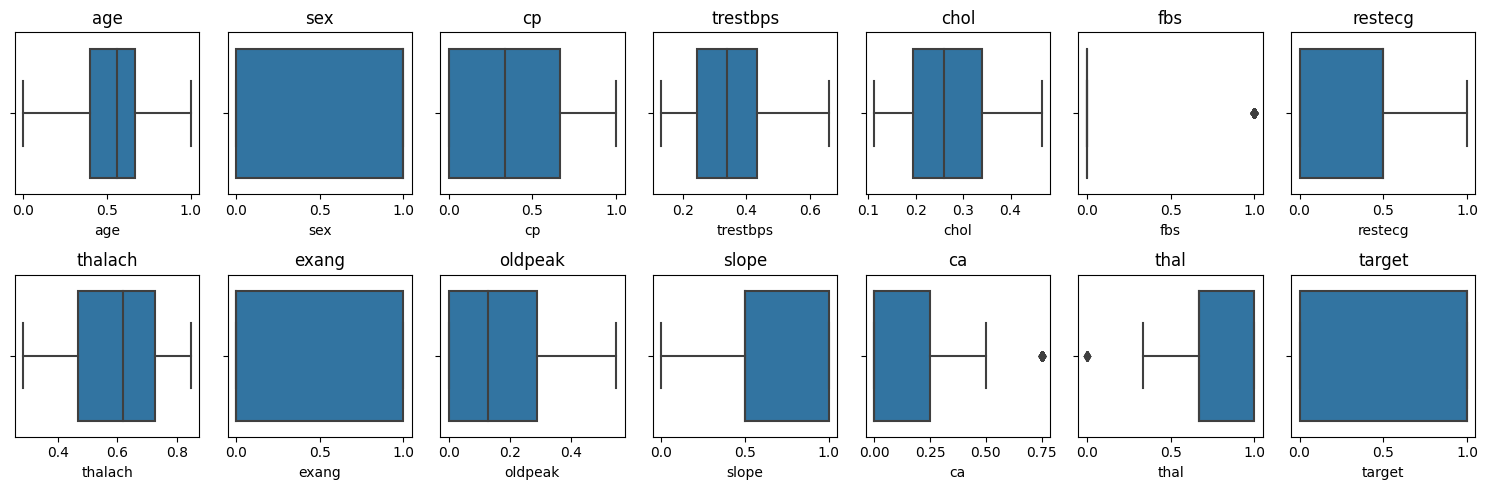

In [ ]:
# Outlier Checking with boxplot after winsorizing

fig, axes = plt.subplots(2, 7, figsize=(15, 5))
axes = axes.flatten()

for i, column in enumerate(df_scale.columns):
    sns.boxplot(x=df_scale[column], ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

age: 0.00% outliers
sex: 0.00% outliers
cp: 0.00% outliers


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


trestbps: 0.00% outliers


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


chol: 0.00% outliers
fbs: 14.93% outliers
restecg: 0.00% outliers


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


thalach: 0.00% outliers
exang: 0.00% outliers
oldpeak: 0.00% outliers
slope: 0.00% outliers


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


ca: 8.49% outliers
thal: 0.68% outliers
target: 0.00% outliers


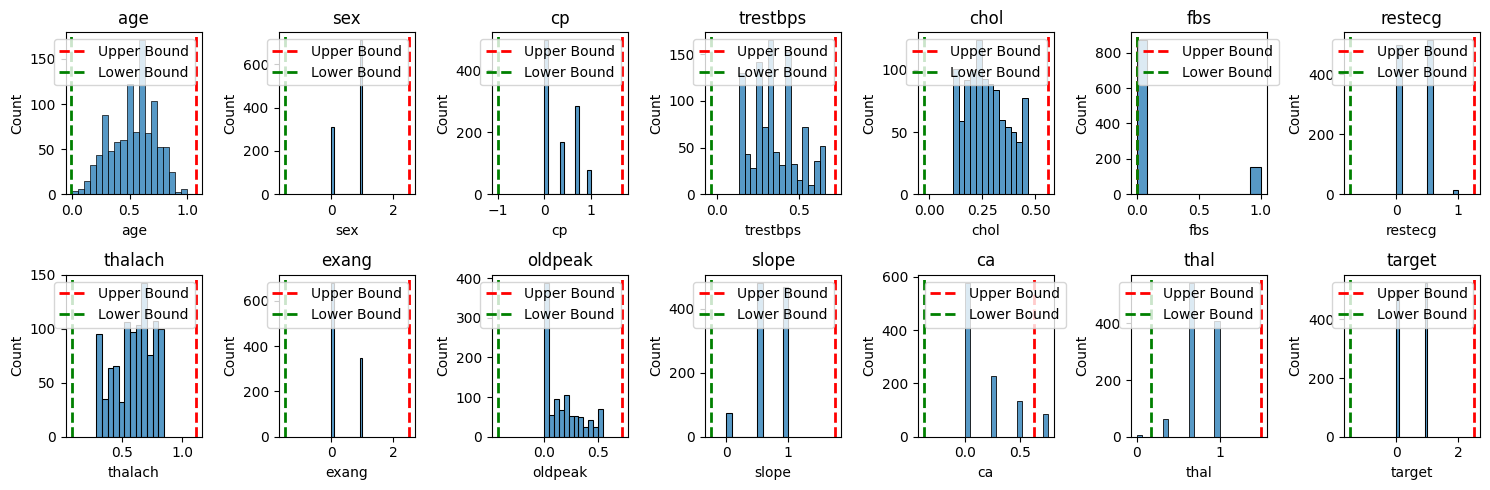

In [ ]:


plt.figure(figsize=(15, 5))
for i, column in enumerate(df_scale.columns, start=1):
    plt.subplot(2, 7, i)

    # Plot histogram
    sns.histplot(x=df_scale[column])
    plt.title(f'{column}')

    q1 = df_scale[column].quantile(0.25)
    q3 = df_scale[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Plot upper and lower bounds
    plt.axvline(upper_bound, color='r', linestyle='dashed', linewidth=2, label='Upper Bound')
    plt.axvline(lower_bound, color='g', linestyle='dashed', linewidth=2, label='Lower Bound')


    outliers_percentage = ((df_scale[column] < lower_bound) | (df_scale[column] > upper_bound)).mean() * 100
    print(f"{column}: {outliers_percentage:.2f}% outliers")
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
df_scale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   float64
 1   sex       1025 non-null   float64
 2   cp        1025 non-null   float64
 3   trestbps  1025 non-null   float64
 4   chol      1025 non-null   float64
 5   fbs       1025 non-null   float64
 6   restecg   1025 non-null   float64
 7   thalach   1025 non-null   float64
 8   exang     1025 non-null   float64
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   float64
 11  ca        1025 non-null   float64
 12  thal      1025 non-null   float64
 13  target    1025 non-null   float64
dtypes: float64(14)
memory usage: 112.2 KB


# Feature Selection Optimization

**A.4 VIF FEATURE SELECTION**

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data

features_for_vif = df_scale[['age','sex', 'cp','trestbps','chol', 'fbs', 'restecg','thalach', 'exang','oldpeak', 'slope', 'ca', 'thal']]
vif_result = calculate_vif(features_for_vif)

# Print the VIF results
print(vif_result)


    Variable        VIF
0        age  10.074950
1        sex   3.589023
2         cp   2.377828
3   trestbps   7.784644
4       chol   8.978640
5        fbs   1.275466
6    restecg   2.040232
7    thalach  15.970715
8      exang   2.079718
9    oldpeak   3.153222
10     slope   9.239446
11        ca   1.924660
12      thal  15.043321


In [ ]:
# print features < VIF = 5
features_to_keep = vif_result[vif_result['VIF'] < 5]['Variable'].tolist()
features_to_keep

['sex', 'cp', 'fbs', 'restecg', 'exang', 'oldpeak', 'ca']

In [ ]:
df_scalenew = df_scale[features_to_keep]

**A.5 SPLIT DATASET USE K FOLD CROSS VALIDATION**

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold

X = df_scalenew
y = df_scale['target']

# k-fold cross-validation
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Split dataset menggunakan k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(k_fold.split(X, y), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]



,sex,cp,fbs,restecg,exang,oldpeak,ca
1,1.0,0.000000,1.0,0.0,1.0,0.500000,0.00
2,1.0,0.000000,0.0,0.5,1.0,0.419355,0.00
3,1.0,0.000000,0.0,0.5,0.0,0.000000,0.25
4,0.0,0.000000,1.0,0.5,0.0,0.306452,0.75
6,1.0,0.000000,0.0,1.0,0.0,0.548387,0.75
...,...,...,...,...,...,...,...
1020,1.0,0.333333,0.0,0.5,1.0,0.000000,0.00
1021,1.0,0.000000,0.0,0.0,1.0,0.451613,0.25
1022,1.0,0.000000,0.0,0.0,1.0,0.161290,0.25
1023,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00


In [ ]:
print("Jumlah data pada data test yaitu : ",y_test.shape)
print("Jumlah data pada data train yaitu : ",y_train.shape)

Jumlah data pada data test yaitu :  (102,)
Jumlah data pada data train yaitu :  (923,)


Jumlah data pada data train yaitu :  (923,)


In [ ]:
y_test

0       0.0
5       1.0
23      1.0
28      0.0
32      0.0
       ... 
1004    1.0
1007    1.0
1009    0.0
1012    0.0
1019    1.0
Name: target, Length: 102, dtype: float64

# CLASSIFICATION

In [ ]:
rf_classifier = RandomForestClassifier()
mlp_classifier = MLPClassifier()
xgb_classifier = XGBClassifier()

**A.6 CARI BEST HYPER PARAMETER SETIAP METODE**

In [ ]:
rf_classifier = RandomForestClassifier()
mlp_classifier = MLPClassifier()
xgb_classifier = XGBClassifier()

rf_param_grid = {'n_estimators': [50, 100, 200],
                 'max_depth': [None, 10, 20],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4]}

mlp_param_grid = {'hidden_layer_sizes': [(100,), (50, 50), (30, 20, 10)],
                  'activation': ['relu', 'tanh'],
                  'alpha': [0.0001, 0.001, 0.01]}

xgb_param_grid = {'n_estimators': [50, 100, 200],
                  'max_depth': [3, 5, 7],
                  'learning_rate': [0.01, 0.1, 0.2]}

# menggunakan GridSearchCV untuk hyperparameter optimization
rf_grid_search = GridSearchCV(rf_classifier, rf_param_grid, cv=k_fold, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

mlp_grid_search = GridSearchCV(mlp_classifier, mlp_param_grid, cv=k_fold, scoring='accuracy')
mlp_grid_search.fit(X_train, y_train)

xgb_grid_search = GridSearchCV(xgb_classifier, xgb_param_grid, cv=k_fold, scoring='accuracy')
xgb_grid_search.fit(X_train, y_train)

# Print best hyperparameters setiap model
print("Random Forest Best Hyperparameters:", rf_grid_search.best_params_)
print("MLP Best Hyperparameters:", mlp_grid_search.best_params_)
print("XGBoost Best Hyperparameters:", xgb_grid_search.best_params_)



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Random Forest Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MLP Best Hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (30, 20, 10)}
XGBoost Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}


**A.7 ULANGI KLASIFIKASI DENGAN BEST HYPER PARAMETER DENGAN FOLD X ITERASI (10X25)**

In [ ]:
X = df_scalenew
y = df_scale['target']

# k-fold cross-validation
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Best parameters obtained from A.6
rf_best_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
mlp_best_params = {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (30, 20, 10)}
xgb_best_params = {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}

# models dengan the best parameters
rf_classifier = RandomForestClassifier(**rf_best_params)
mlp_classifier = MLPClassifier(**mlp_best_params)
xgb_classifier = XGBClassifier(**xgb_best_params)

# total iterasi 25x
n_iterations = 25

# Fungsi perulangan
def perulangan_klasifikasi(model, X, y, n_iterations, k_fold):
    accuracies = []
    recalls = []
    precisions = []
    f1_scores = []
    computation_times = []
    print(f"{model}\n")
    for _ in range(n_iterations):
        start_time = time.time()

        for train_idx, test_idx in k_fold.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracies.append(accuracy_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            precisions.append(precision_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))

        end_time = time.time()
        computation_time = end_time - start_time
        computation_times.append(computation_time)

        # Print metrics for each iteration
        print(f"Iterasi ke {_+1}")
        print("-----------------------------------------------")
        print("Akurasi :", accuracy_score(y_test, y_pred))
        print("Recall   :", recall_score(y_test, y_pred))
        print("Presisi  :", precision_score(y_test, y_pred))
        print("F1 Score :", f1_score(y_test, y_pred))
        print(f"Waktu Komputasi: {computation_time}\n")
        print("-----------------------------------------------")

    print("=================================================")
    print(f"Metrics rata-rata {n_iterations} iterations:")
    print("Average Akurasi :", np.mean(accuracies))
    print("Average Recall   :", np.mean(recalls))
    print("Average Presisi  :", np.mean(precisions))
    print("Average F1 Score :", np.mean(f1_scores))
    print(f"Average Waktu Komputasi : {np.mean(computation_times)}")
    print("=================================================")

    return accuracies, recalls, precisions, f1_scores, computation_times

rf_accuracies, rf_recalls, rf_precisions, rf_f1_scores, rf_computation_times = perulangan_klasifikasi(
    rf_classifier, X, y, n_iterations, k_fold
)

RandomForestClassifier()

Iterasi ke 1
-----------------------------------------------
Akurasi : 0.9509803921568627
Recall   : 0.9622641509433962
Presisi  : 0.9444444444444444
F1 Score : 0.9532710280373832
Waktu Komputasi: 6.8480823040008545

-----------------------------------------------
Iterasi ke 2
-----------------------------------------------
Akurasi : 0.9509803921568627
Recall   : 0.9622641509433962
Presisi  : 0.9444444444444444
F1 Score : 0.9532710280373832
Waktu Komputasi: 2.063610315322876

-----------------------------------------------
Iterasi ke 3
-----------------------------------------------
Akurasi : 0.9509803921568627
Recall   : 0.9622641509433962
Presisi  : 0.9444444444444444
F1 Score : 0.9532710280373832
Waktu Komputasi: 2.0200231075286865

-----------------------------------------------
Iterasi ke 4
-----------------------------------------------
Akurasi : 0.9509803921568627
Recall   : 0.9622641509433962
Presisi  : 0.9444444444444444
F1 Score : 0.9532710280373832


In [ ]:
mlp_accuracies, mlp_recalls, mlp_precisions, mlp_f1_scores, mlp_computation_times = perulangan_klasifikasi(
    mlp_classifier, X, y, n_iterations, k_fold
)


MLPClassifier(alpha=0.01, hidden_layer_sizes=(30, 20, 10))



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 1
-----------------------------------------------
Akurasi : 0.803921568627451
Recall   : 0.8490566037735849
Presisi  : 0.7894736842105263
F1 Score : 0.8181818181818182
Waktu Komputasi: 11.91982626914978

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 2
-----------------------------------------------
Akurasi : 0.8137254901960784
Recall   : 0.8679245283018868
Presisi  : 0.7931034482758621
F1 Score : 0.8288288288288289
Waktu Komputasi: 8.781286001205444

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 3
-----------------------------------------------
Akurasi : 0.8235294117647058
Recall   : 0.8867924528301887
Presisi  : 0.7966101694915254
F1 Score : 0.8392857142857143
Waktu Komputasi: 11.346969604492188

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 4
-----------------------------------------------
Akurasi : 0.8333333333333334
Recall   : 0.8867924528301887
Presisi  : 0.8103448275862069
F1 Score : 0.8468468468468469
Waktu Komputasi: 10.30540418624878

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 5
-----------------------------------------------
Akurasi : 0.8235294117647058
Recall   : 0.9056603773584906
Presisi  : 0.7868852459016393
F1 Score : 0.8421052631578947
Waktu Komputasi: 9.572447299957275

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 6
-----------------------------------------------
Akurasi : 0.8431372549019608
Recall   : 0.8679245283018868
Presisi  : 0.8363636363636363
F1 Score : 0.8518518518518519
Waktu Komputasi: 11.301917791366577

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 7
-----------------------------------------------
Akurasi : 0.8431372549019608
Recall   : 0.9056603773584906
Presisi  : 0.8135593220338984
F1 Score : 0.8571428571428572
Waktu Komputasi: 8.262916803359985

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 8
-----------------------------------------------
Akurasi : 0.8529411764705882
Recall   : 0.9056603773584906
Presisi  : 0.8275862068965517
F1 Score : 0.8648648648648648
Waktu Komputasi: 12.002285718917847

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 9
-----------------------------------------------
Akurasi : 0.8235294117647058
Recall   : 0.8490566037735849
Presisi  : 0.8181818181818182
F1 Score : 0.8333333333333334
Waktu Komputasi: 25.322700023651123

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 10
-----------------------------------------------
Akurasi : 0.8529411764705882
Recall   : 0.8867924528301887
Presisi  : 0.8392857142857143
F1 Score : 0.8623853211009174
Waktu Komputasi: 15.987444639205933

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 11
-----------------------------------------------
Akurasi : 0.8529411764705882
Recall   : 0.8867924528301887
Presisi  : 0.8392857142857143
F1 Score : 0.8623853211009174
Waktu Komputasi: 13.610002756118774

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 12
-----------------------------------------------
Akurasi : 0.8235294117647058
Recall   : 0.8679245283018868
Presisi  : 0.8070175438596491
F1 Score : 0.8363636363636363
Waktu Komputasi: 8.55543327331543

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 13
-----------------------------------------------
Akurasi : 0.8137254901960784
Recall   : 0.8679245283018868
Presisi  : 0.7931034482758621
F1 Score : 0.8288288288288289
Waktu Komputasi: 10.761343717575073

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 14
-----------------------------------------------
Akurasi : 0.8529411764705882
Recall   : 0.8867924528301887
Presisi  : 0.8392857142857143
F1 Score : 0.8623853211009174
Waktu Komputasi: 9.42292332649231

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 15
-----------------------------------------------
Akurasi : 0.8333333333333334
Recall   : 0.8679245283018868
Presisi  : 0.8214285714285714
F1 Score : 0.8440366972477065
Waktu Komputasi: 9.952083349227905

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 16
-----------------------------------------------
Akurasi : 0.8529411764705882
Recall   : 0.9056603773584906
Presisi  : 0.8275862068965517
F1 Score : 0.8648648648648648
Waktu Komputasi: 10.262778759002686

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 17
-----------------------------------------------
Akurasi : 0.8431372549019608
Recall   : 0.8867924528301887
Presisi  : 0.8245614035087719
F1 Score : 0.8545454545454546
Waktu Komputasi: 9.022907972335815

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 18
-----------------------------------------------
Akurasi : 0.8431372549019608
Recall   : 0.8679245283018868
Presisi  : 0.8363636363636363
F1 Score : 0.8518518518518519
Waktu Komputasi: 11.523706912994385

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 19
-----------------------------------------------
Akurasi : 0.8529411764705882
Recall   : 0.8867924528301887
Presisi  : 0.8392857142857143
F1 Score : 0.8623853211009174
Waktu Komputasi: 8.12545657157898

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 20
-----------------------------------------------
Akurasi : 0.8529411764705882
Recall   : 0.9056603773584906
Presisi  : 0.8275862068965517
F1 Score : 0.8648648648648648
Waktu Komputasi: 11.201798915863037

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 21
-----------------------------------------------
Akurasi : 0.8627450980392157
Recall   : 0.9622641509433962
Presisi  : 0.8095238095238095
F1 Score : 0.8793103448275862
Waktu Komputasi: 15.936235904693604

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 22
-----------------------------------------------
Akurasi : 0.8529411764705882
Recall   : 0.9056603773584906
Presisi  : 0.8275862068965517
F1 Score : 0.8648648648648648
Waktu Komputasi: 8.30635690689087

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 23
-----------------------------------------------
Akurasi : 0.8529411764705882
Recall   : 0.9056603773584906
Presisi  : 0.8275862068965517
F1 Score : 0.8648648648648648
Waktu Komputasi: 11.106319904327393

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 24
-----------------------------------------------
Akurasi : 0.8627450980392157
Recall   : 0.9433962264150944
Presisi  : 0.819672131147541
F1 Score : 0.8771929824561403
Waktu Komputasi: 8.019879817962646

-----------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Iterasi ke 25
-----------------------------------------------
Akurasi : 0.8333333333333334
Recall   : 0.9056603773584906
Presisi  : 0.8
F1 Score : 0.8495575221238938
Waktu Komputasi: 10.907098531723022

-----------------------------------------------
Metrics rata-rata 25 iterations:
Average Akurasi : 0.8711772320578718
Average Recall   : 0.9020348330914367
Average Presisi  : 0.8565673545342517
Average F1 Score : 0.8779710465367225
Average Waktu Komputasi : 11.260700998306275


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:

xgb_accuracies, xgb_recalls, xgb_precisions, xgb_f1_scores, xgb_computation_times = perulangan_klasifikasi(
    xgb_classifier, X, y, n_iterations, k_fold
)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Iterasi ke 1
-----------------------------------------------
Akurasi : 0.9509803921568627
Recall   : 0.9622641509433962
Presisi  : 0.9444444444444444
F1 Score : 0.9532710280373832
Waktu Komputasi: 1.0648066997528076

-----------------------------

# INSIGHT

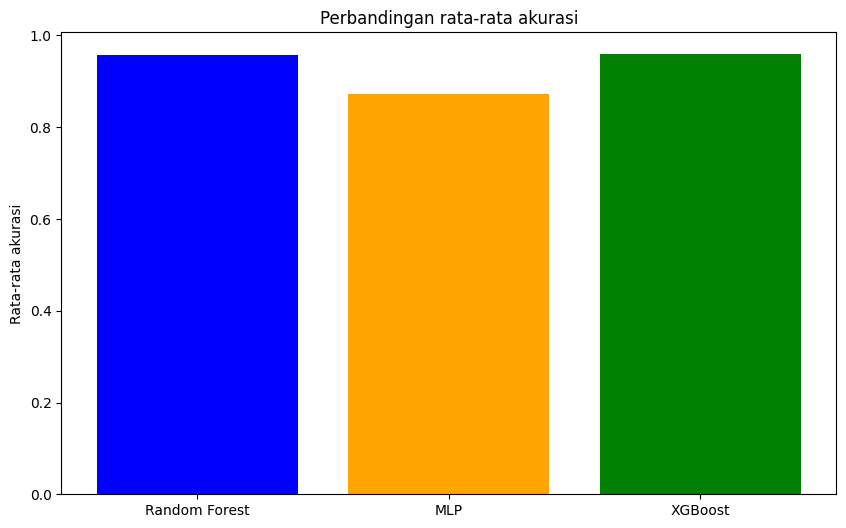

In [ ]:

labels = ['Random Forest', 'MLP', 'XGBoost']
accuracies_means = [np.mean(rf_accuracies), np.mean(mlp_accuracies), np.mean(xgb_accuracies)]
recalls_means = [np.mean(rf_recalls), np.mean(mlp_recalls), np.mean(xgb_recalls)]
precisions_means = [np.mean(rf_precisions), np.mean(mlp_precisions), np.mean(xgb_precisions)]
f1_scores_means = [np.mean(rf_f1_scores), np.mean(mlp_f1_scores), np.mean(xgb_f1_scores)]
computation_times_means = [np.mean(rf_computation_times), np.mean(mlp_computation_times), np.mean(xgb_computation_times)]

# AKURASI
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies_means, color=['blue', 'orange', 'green'])
plt.title('Perbandingan rata-rata akurasi')
plt.ylabel('Rata-rata akurasi')
plt.show()



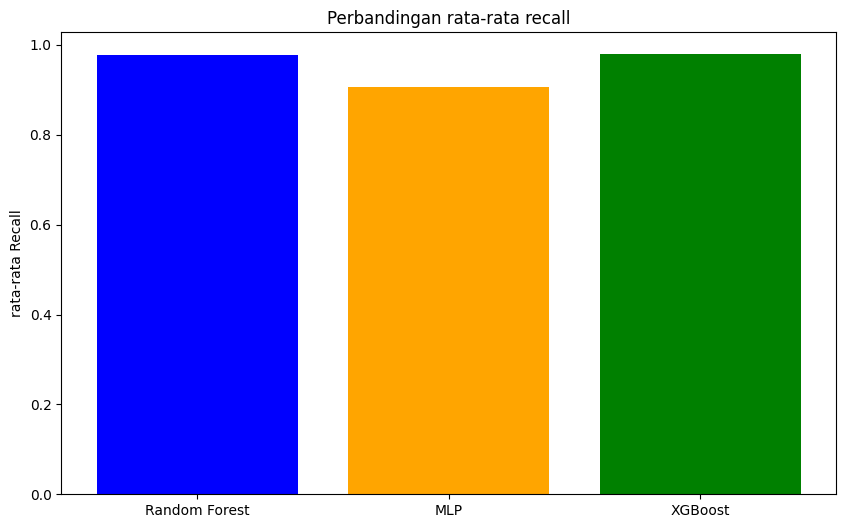

In [ ]:
# RECALL
plt.figure(figsize=(10, 6))
plt.bar(labels, recalls_means, color=['blue', 'orange', 'green'])
plt.title('Perbandingan rata-rata recall')
plt.ylabel('rata-rata Recall')
plt.show()



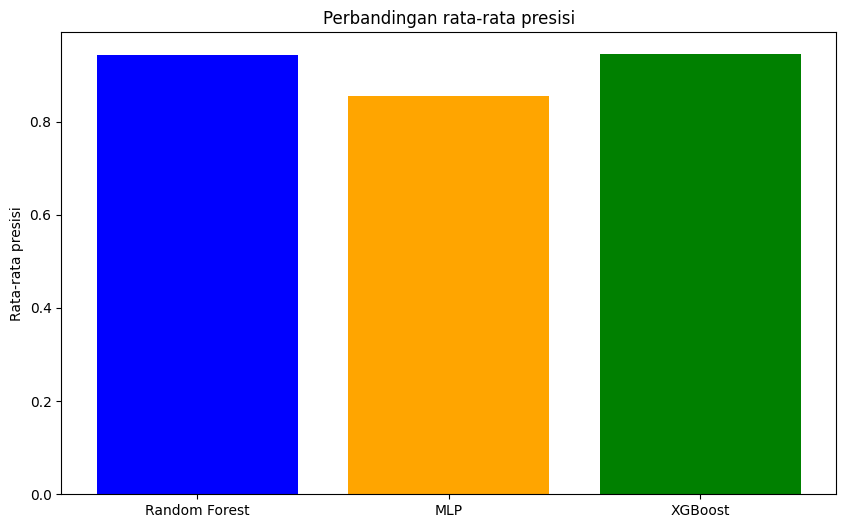

In [ ]:
# precision
plt.figure(figsize=(10, 6))
plt.bar(labels, precisions_means, color=['blue', 'orange', 'green'])
plt.title('Perbandingan rata-rata presisi')
plt.ylabel('Rata-rata presisi')
plt.show()



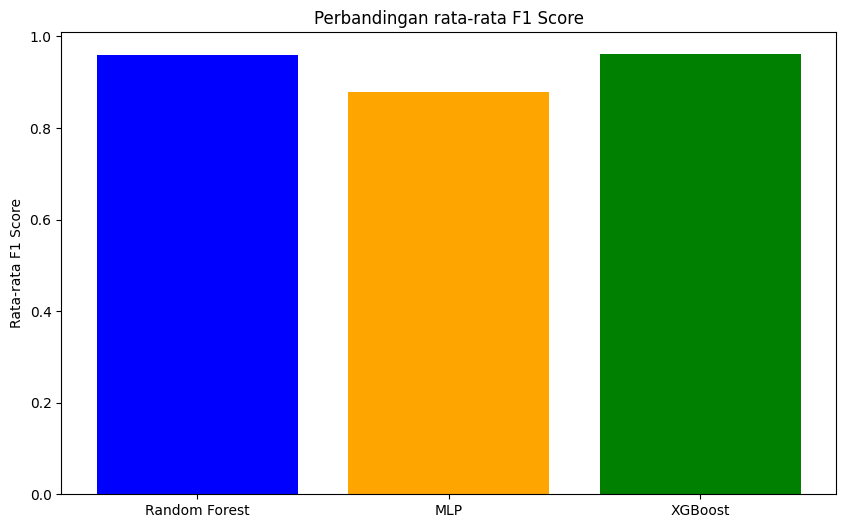

In [ ]:
# F1 score
plt.figure(figsize=(10, 6))
plt.bar(labels, f1_scores_means, color=['blue', 'orange', 'green'])
plt.title('Perbandingan rata-rata F1 Score')
plt.ylabel('Rata-rata F1 Score')
plt.show()



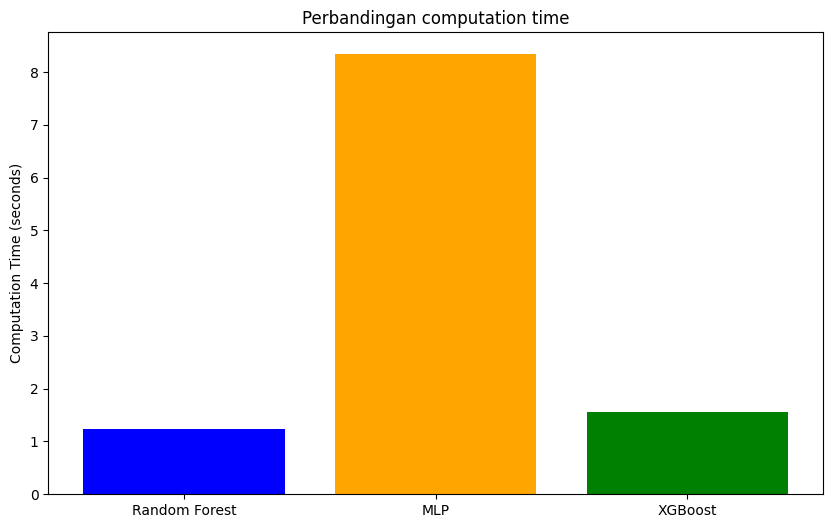

In [ ]:
# computation time
plt.figure(figsize=(10, 6))
plt.bar(labels, computation_times_means, color=['blue', 'orange', 'green'])
plt.title('Perbandingan computation time')
plt.ylabel('Computation Time (seconds)')
plt.show()

In [ ]:
accuracies_means = [np.mean(rf_accuracies), np.mean(mlp_accuracies), np.mean(xgb_accuracies)]
accuracies_means


[0.9578903483723588, 0.8719150961355416, 0.9589948600799544]

In [ ]:
recalls_means = [np.mean(rf_recalls), np.mean(mlp_recalls), np.mean(xgb_recalls)]
recalls_means

[0.9782075471698113, 0.9060304789550072, 0.979100145137881]

In [ ]:
f1_scores_means

[0.9599602451202635, 0.8791567412222132, 0.961023020807973]

In [ ]:
precisions_means

[0.9433165437769909, 0.8551327175457483, 0.944420751073612]

In [ ]:
computation_times_means #detik

[1.2322888660430908, 8.336333293914794, 1.5641004848480224]

Dari tiga metode klasifikasi diatas
- XGboost memiliki nilai akurasi tertinggi
- Random Forest memiliki nilai recall, presisi, dan F1-Score tertinggi.
- Berdasarkan rata-rata computaion time saat proses 25 iterasi dengan 10 fold  paling cepat diraih oleh Random Forest dan paling lama diraih oleh Multilayer Perception.

1. Accuracy:
   - RF vs MLP: Terdapat perbedaan yang signifikan dalam akurasi antara RF dan MLP karena nilai statistik uji tinggi dan p-value sangat rendah.
   - RF vs XGB: Tidak terdapat perbedaan signifikan dalam akurasi antara RFdan XGB karena p-value > 0.05
  - MLP vs XGB: Terdapat perbedaan yang signifikan dalam akurasi antara MLP dan XGB karena nilai statistik uji tinggi dan p-value sangat rendah.

2. Recall:
   - RF vs MLP: Terdapat perbedaan yang signifikan dalam recall antara RF dan MLP karena nilai statistik uji tinggi dan p-value sangat rendah.
   - RF vs XGB: Tidak terdapat perbedaan signifikan dalam recall antara RF dan XGB karena p-value > 0.05.
   - MLP vs XGB: Terdapat perbedaan yang signifikan dalam recall antara MLP dan XGB karena nilai statistik uji tinggi dan p-value sangat rendah.

3. Precision:
   - RF vs MLP: Terdapat perbedaan yang signifikan dalam precision antara RF dan MLP karena nilai statistik uji tinggi dan p-value sangat rendah.
   - RF vs XGB: Terdapat perbedaan yang signifikan dalam precision antara RF dan XGB karena nilai statistik uji rendah dan p-value rendah.
   - MLP vs XGB: Terdapat perbedaan yang signifikan dalam precision antara MLP dan XGB karena nilai statistik uji tinggi dan p-value sangat rendah.

4. F1 Score:
   - RF vs MLP: Terdapat perbedaan yang signifikan dalam F1 Score antara RF dan MLP karena nilai statistik uji tinggi dan p-value sangat rendah.
   - RF vs XGB: Tidak terdapat perbedaan signifikan dalam F1 Score antara RF dan XGB karena p-value > 0.05.
   - MLP vs XGB: Terdapat perbedaan yang signifikan dalam F1 Score antara MLP dan XGB karena nilai statistik uji tinggi dan p-value sangat rendah.
